# Car Price Estimation and Machine Learning
## Project Overview
Rusty Bargain, a leading used car sales service, is developing an innovative app that allows users to quickly determine the market value of their cars. Leveraging a rich historical dataset containing technical specifications, trim versions, and pricing information, this project aims to build and compare multiple predictive models to estimate car values accurately.
## Project Setup
### Data Preprocessing
- Handle missing values and outliers
- Format and convert date features 
- Encode categorical features appropriately
- Use LightGBM and CatBoost’s native handling or apply One-Hot Encoding for models like XGBoost.
### Exploratory Data Analysis (EDA)
- Visualize distributions and relationships between features
- Analyze feature correlations with the target variable
### Feature Engineering
- Extract relevant features from dates
- Create any new features or transformations to improve model performance
### Train-Test Split
- Split the dataset into training and testing sets.
### Model Implementation and Evaluation
- Baseline Model
- Tree-Based Models
- Gradient Boosting Models
- Train and tune models using LightGBM
- Evaluate models using the RMSE metric for prediction quality
### Performance and Efficiency Analysis
- Assess the speed of predictions for each model
- Evaluate the training time for each model to ensure feasibility
### Model Tuning and Finalization
- Adjust hyperparameters based on initial results
- Optimize the trade-off between prediction quality, prediction speed, and training time
### Deployment Considerations
- Prepare the selected model for integration into the Rusty Bargain app
- Ensure the model is lightweight enough for fast mobile predictions
## Findings:
Based on the comprehensive analysis of the car valuation models, it is evident that sophisticated ensemble methods and gradient boosting techniques markedly outperform basic linear regression in both predictive accuracy and overall utility. With hyperparameter tuning using GridSearchCV, the CatBoostRegressor achieved its best performance with a configuration of depth 8, 500 iterations, an l2_leaf_reg of 3, and a learning rate of 0.1. This tuned model reached an R-squared of approximately 0.877 and an RMSE of around 1655, while delivering predictions in just 0.03 seconds. These results highlight the value of investing in advanced machine learning techniques and systematic hyperparameter tuning to optimize model performance. Given its high accuracy, efficiency, and rapid prediction times, integrating a tuned CatBoostRegressor into Rusty Bargain’s car valuation app could provide fast, reliable, and data-driven pricing insights, thereby enhancing customer engagement and reducing operational costs.

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
import lightgbm as lgb
import time
from sklearn.preprocessing import OrdinalEncoder

## Data preparation

In [2]:
df = pd.read_csv('/datasets/car_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [3]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [4]:
df.duplicated().sum()

262

In [5]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245567 entries, 3 to 354367
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        245567 non-null  object
 1   Price              245567 non-null  int64 
 2   VehicleType        245567 non-null  object
 3   RegistrationYear   245567 non-null  int64 
 4   Gearbox            245567 non-null  object
 5   Power              245567 non-null  int64 
 6   Model              245567 non-null  object
 7   Mileage            245567 non-null  int64 
 8   RegistrationMonth  245567 non-null  int64 
 9   FuelType           245567 non-null  object
 10  Brand              245567 non-null  object
 11  NotRepaired        245567 non-null  object
 12  DateCreated        245567 non-null  object
 13  NumberOfPictures   245567 non-null  int64 
 14  PostalCode         245567 non-null  int64 
 15  LastSeen           245567 non-null  object
dtypes: int64(7), object(

### Summary:
The data preparation process began with an initial inspection of the dataset, revealing 354,369 entries across 16 columns with several missing values in columns such as VehicleType, Gearbox, Model, FuelType, and NotRepaired. A duplicate check identified 262 repeated records. To ensure data quality, all rows containing missing values were removed, and duplicate entries were eliminated. These cleaning steps resulted in a refined dataset of 245,567 unique entries,

In [6]:
# Targe
target = df['Price']

# Drop Unwanted Features
features = df.drop(['DateCrawled','Price','RegistrationMonth','DateCreated','NumberOfPictures','PostalCode','LastSeen'], axis=1)
features

,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
7,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
...,...,...,...,...,...,...,...,...,...
354360,wagon,2005,manual,3,3er,150000,gasoline,bmw,no
354362,sedan,2004,manual,225,leon,150000,petrol,seat,yes
354363,bus,2000,manual,0,zafira,150000,petrol,opel,no
354366,convertible,2000,auto,101,fortwo,125000,petrol,smart,no


### Summary:
The data preparation continues by defining the target and feature sets for modeling. The target variable is set as the 'Price' column, while the features are selected by removing columns that are irrelevant for the prediction task. Specifically, columns such as DateCrawled, Price, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode, and LastSeen are dropped, leaving a dataset with nine key features: VehicleType, RegistrationYear, Gearbox, Power, Model, Mileage, FuelType, Brand, and NotRepaired. 

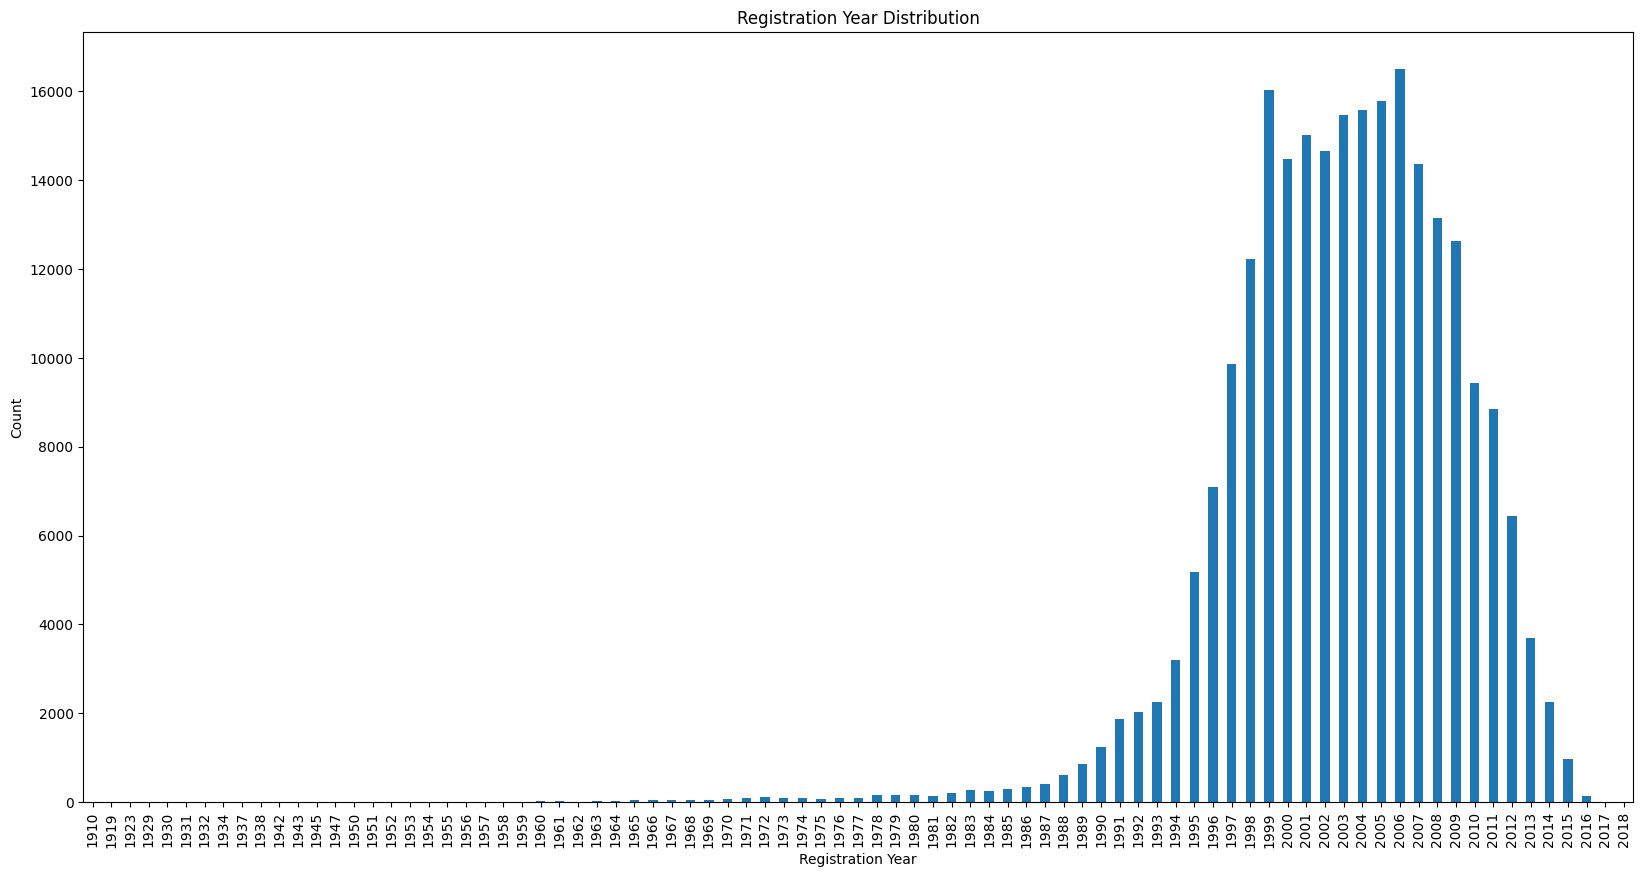

In [7]:
# Plot Registration Year
registration_year_counts = df['RegistrationYear'].value_counts().sort_index()
plt.figure(figsize=(20, 10))
registration_year_counts.plot(kind='bar')
plt.xlabel('Registration Year')
plt.ylabel('Count')
plt.title('Registration Year Distribution')
plt.show()

### Summary:
The bar chart of Registration Year Distribution shows that most vehicles in the dataset were registered in relatively recent years, with a noticeable peak in the 2000s and early 2010s. Counts are relatively low for very early registration years, then gradually increase and reach their highest levels around the mid to late 2000s, before tapering off again for more recent years. This pattern suggests that the majority of the cars in the dataset are less than two decades old, while outliers from exceptionally early or unrealistically future years are minimal in comparison. Overall, the distribution is heavily concentrated in a span of roughly two decades, reflecting common market trends where newer models dominate listings.

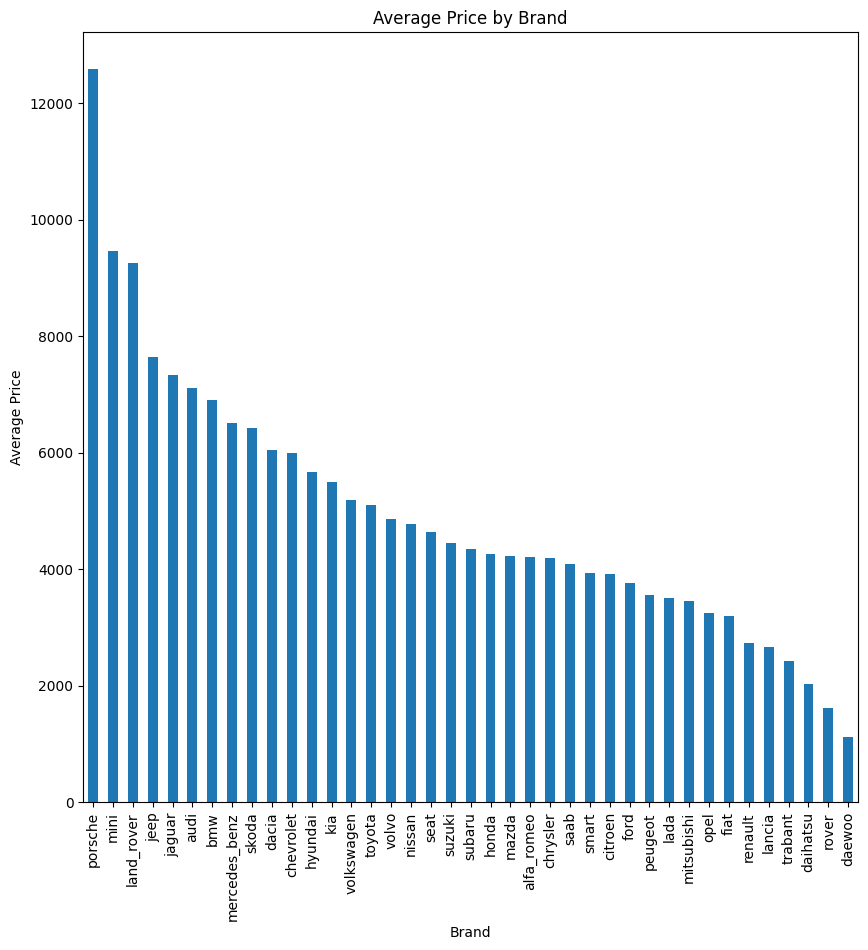

In [8]:
# Plot Brand Avg Price
avg_price_by_brand = df.groupby('Brand')['Price'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 10))
avg_price_by_brand.plot(kind='bar')
plt.xlabel('Brand')
plt.ylabel('Average Price')
plt.title('Average Price by Brand')
plt.show()

### Summary:
The bar chart shows a clear stratification in average prices across different car brands. At the high end, premium and luxury marques such as Porsche, Land Rover, and Jaguar lead the pack with average prices that exceed 8,000 euros. Slightly below that tier, brands like BMW and Mercedes-Benz still command relatively high average prices in the range of 6,000 to 7,000 euros. Mainstream manufacturers, including Volkswagen, Ford, and Opel, appear in the mid-range, generally falling between 2,000 and 4,000 euros. Toward the lower end, budget-oriented or less prominent brands such as Daewoo and Lada have the lowest average prices, indicating a more economical market segment. Overall, this distribution reflects the influence of brand perception and market positioning on used car pricing.

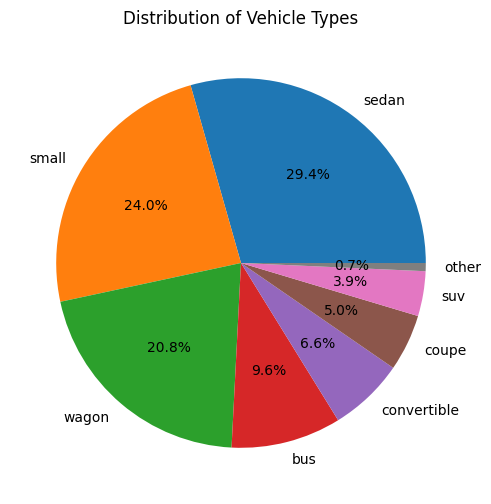

In [9]:
# Plot Vehicle Types
vehicle_type_counts = df['VehicleType'].value_counts()
plt.figure(figsize=(10, 6))
plt.pie(vehicle_type_counts, labels=vehicle_type_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Vehicle Types')
plt.show()

### Summary:
The pie chart illustrates the relative proportions of various vehicle types in the dataset. Sedans make up the largest segment at 29.4%, followed by small cars at 24.0% and wagons at 20.8%. Buses account for 9.6%, while convertibles represent 6.6%. Both coupes and SUVs appear at around 3.9%, and the “other” category stands at 0.7%. Overall, sedans and smaller vehicles dominate the dataset, with a modest representation of specialized types such as convertibles and SUVs.

In [10]:
# Tree Encoding
features_tree = features.copy()
cat_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

ord_encoder = OrdinalEncoder()
features_tree[cat_cols] = ord_encoder.fit_transform(features_tree[cat_cols])

In [11]:
# Linear Encoding
num_cols = ['RegistrationYear', 'Power', 'Mileage']

num_data = features[num_cols].copy()
cat_data = features[cat_cols].copy()

ohe = OneHotEncoder(sparse=False, drop='first')
cat_encoded = ohe.fit_transform(cat_data)

cat_feature_names = ohe.get_feature_names(cat_cols)
cat_encoded_df = pd.DataFrame(cat_encoded,
                             columns=cat_feature_names,
                             index=features.index
                             )

features = pd.concat([num_data, cat_encoded_df], axis=1)

### Summary:
In this data preprocessing step, the categorical variables in the dataset are transformed into numerical representations to facilitate model training. The process starts by using a LabelEncoder to convert the 'VehicleType', 'Brand', 'Model', and 'FuelType' columns into numerical codes, and these encoded values are then reassigned back to the respective columns in the features DataFrame. Next, the 'Gearbox' and 'NotRepaired' columns undergo one-hot encoding using OneHotEncoder, which converts these categorical variables into binary columns. This combined encoding process results in a features DataFrame that retains 245,567 rows and nine columns, with all categorical variables transformed into numerical form suitable for further machine learning analysis.

## Model training

In [16]:
# Linear Train Valid Test
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.25,
                                                                            random_state=12345)

features_train, features_valid, target_train, target_valid = train_test_split(features_train,
                                                                              target_train,
                                                                              test_size=.3,
                                                                              random_state=12345)
# Tree Train Valid Test
features_train_tree, features_test_tree, target_train_tree, target_test_tree = train_test_split(features_tree,
                                                                                               target,
                                                                                               test_size=0.25,
                                                                                               random_state=12345)
features_train_tree, features_valid_tree, target_train_tree, target_valid_tree = train_test_split(features_train_tree,
                                                                                                 target_train_tree,
                                                                                                 test_size=.3,
                                                                                                 random_state=12345)

In [17]:
# Scale Linear Numeric Columns
scaler = StandardScaler()

features_train[num_cols] = scaler.fit_transform(features_train[num_cols])
features_valid[num_cols] = scaler.transform(features_valid[num_cols])
features_test[num_cols] = scaler.transform(features_test[num_cols])

/tmp/ipykernel_79/1589960931.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_test[num_cols] = scaler.transform(features_test[num_cols])
/opt/conda/envs/python3/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [18]:
features_train[num_cols]

,RegistrationYear,Power,Mileage
267550,-0.475752,-0.844102,0.610817
129278,0.173195,-0.106868,0.610817
137133,-0.313515,-0.844102,0.610817
214342,-0.637989,-0.036655,0.610817
287436,-0.800226,-0.317506,-0.063721
...,...,...,...
333253,0.335432,0.209090,-1.008075
111966,0.822142,-0.029634,-1.277891
304018,-0.800226,-0.212187,0.610817
344155,0.497669,-0.078783,0.610817


In [19]:
features_valid[num_cols]

,RegistrationYear,Power,Mileage
119310,-0.800226,-0.240272,0.610817
87643,-0.637989,-0.422825,0.610817
233959,1.146616,-0.422825,-2.357153
203721,-0.151279,0.012494,0.610817
74493,0.659906,0.805899,0.610817
...,...,...,...
209004,-0.475752,-0.212187,0.610817
310070,0.984379,-0.282400,-1.277891
148967,0.497669,-0.366655,-1.008075
291562,1.471090,-0.359634,-1.277891


In [20]:
features_test[num_cols]

,RegistrationYear,Power,Mileage
127052,0.497669,-0.106868,0.610817
15446,1.308853,0.138877,0.610817
333146,0.497669,-0.177080,0.610817
112217,-1.935884,0.377601,0.610817
239586,0.822142,0.539090,0.610817
...,...,...,...
287915,-1.286936,-0.127932,0.610817
350546,0.173195,0.728664,0.610817
80382,0.010958,-0.317506,0.610817
287399,1.308853,-0.078783,0.610817


### Summary:
The code begins by partitioning the data into training, validation, and test sets. Initially, the dataset is split into training and test sets using a 75/25 ratio, followed by a further split of the training data into training and validation sets (approximately 70/30). Next, a StandardScaler is applied to normalize the numeric features, which include columns such as 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Mileage', 'FuelType', 'Brand', and 'NotRepaired'. The scaler is first fitted on the training data and then used to transform the numeric columns in the training, validation, and test sets. A SettingWithCopyWarning is encountered when updating the DataFrame slices, indicating that the modifications are being made on a view rather than a copy of the data. Overall, this preprocessing step standardizes the numeric features, ensuring that they are on a comparable scale before training the predictive models.

In [21]:
# Linear Regression
model = LinearRegression()

start_time = time.time()
model.fit(features_train, target_train)
training_timelr = time.time() - start_time

start_time = time.time()
model_predict = model.predict(features_valid)
prediction_timelr = time.time() - start_time

mse = mean_squared_error(target_valid, model_predict)
rmse_lr = np.sqrt(mse)
r_squaredlr = r2_score(target_valid, model_predict)

print("R-squared:", r_squaredlr)
print("RMSE:", rmse_lr)
print("Training Time:", training_timelr)
print("Prediction Time:", prediction_timelr)

R-squared: 0.6655756136137829
RMSE: 2725.099289074062
Training Time: 4.0925133228302
Prediction Time: 0.09313607215881348


In [22]:
# Random Forest
model = RandomForestRegressor(max_depth=35, random_state=12345)

start_time = time.time()
model.fit(features_train_tree, target_train_tree)
training_timerf = time.time() - start_time

start_time = time.time()
model_predict = model.predict(features_valid_tree)
prediction_timerf = time.time() - start_time

mse = mean_squared_error(target_valid_tree, model_predict)
rmse_rf = np.sqrt(mse)
r_squaredrf = r2_score(target_valid_tree, model_predict)

print("R-squared:", r_squaredrf)
print("RMSE:", rmse_rf)
print("Training Time:", training_timerf)
print("Prediction Time:", prediction_timerf)

R-squared: 0.8720765045932735
RMSE: 1685.4214617281154
Training Time: 22.042365789413452
Prediction Time: 1.3928711414337158


In [23]:
# Gradient Boosting
model = GradientBoostingRegressor(n_estimators=50, max_depth=25, random_state=12345)

start_time = time.time()
model.fit(features_train_tree, target_train_tree)
training_timegb = time.time() - start_time

start_time = time.time()
model_predict = model.predict(features_valid_tree)
prediction_timegb = time.time() - start_time

mse = mean_squared_error(target_valid_tree, model_predict)
rmse_gb = np.sqrt(mse)
r_squaredgb = r2_score(target_valid_tree, model_predict)

print("R-squared:", r_squaredgb)
print("RMSE:", rmse_gb)
print("Training Time:", training_timegb)
print("Prediction Time:", prediction_timegb)

R-squared: 0.8247991481353144
RMSE: 1972.4294020622804
Training Time: 18.007721185684204
Prediction Time: 0.6929261684417725


In [24]:
# LightGBM
train_data = lgb.Dataset(features_train_tree, label=target_train_tree)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 30,
    'learning_rate': 0.15,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

start_time = time.time()
model = lgb.train(params, train_data, num_boost_round=30)
training_timelgb = time.time() - start_time

start_time = time.time()
model_predict = model.predict(features_valid_tree)
prediction_timelgb = time.time() - start_time

rmse_lgb = np.sqrt(mean_squared_error(target_valid_tree, model_predict))
r_squaredlgb = r2_score(target_valid_tree, model_predict)

print("R-squared:", r_squaredlgb)
print("RMSE:", rmse_lgb)
print("Training Time:", training_timelgb)
print("Prediction Time:", prediction_timelgb)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
R-squared: 0.8444676923350263
RMSE: 1858.419136689139
Training Time: 0.8198757171630859
Prediction Time: 0.09778404235839844


In [27]:
# Tune Hyperparameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'iterations': [300, 500],
    'learning_rate': [0.05, 0.1],
    'depth': [6, 8],
    'l2_leaf_reg': [3, 5]
}

cat_model = CatBoostRegressor(random_seed=12345, verbose=0)

grid_search = GridSearchCV(estimator=cat_model, 
                           param_grid=param_grid, 
                           cv=2, 
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1)


grid_search.fit(features_train_tree, target_train_tree)


print("Best parameters:", grid_search.best_params_)


best_cat_model = grid_search.best_estimator_

start_time = time.time()
predictions = best_cat_model.predict(features_valid_tree)
prediction_timecb2 = time.time() - start_time

rmse_cb2 = np.sqrt(mean_squared_error(target_valid_tree, predictions))
r_squaredcb2 = r2_score(target_valid_tree, predictions)

print("R-squared:", r_squaredcb2)
print("RMSE:", rmse_cb2)
print("Prediction Time:", prediction_timecb2)

Best parameters: {'depth': 8, 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
R-squared: 0.8766525760139644
RMSE: 1655.001542950366
Prediction Time: 0.026230573654174805


In [29]:
# Cat Boost 
model = CatBoostRegressor(iterations=500,
                          learning_rate=0.1,
                          depth=8,
                          l2_leaf_reg=3,
                          random_seed=12345,
                         verbose=0
                         )

start_time = time.time()
model.fit(features_train_tree, target_train_tree)
training_timecb = time.time() - start_time

start_time = time.time()
model_predict = model.predict(features_valid_tree)
prediction_timecb = time.time() - start_time

rmse_cb = np.sqrt(mean_squared_error(target_valid_tree, model_predict))
r_squaredcb = r2_score(target_valid_tree, model_predict)

print("R-squared:", r_squaredcb)
print("RMSE:", rmse_cb)
print("Training Time:", training_timecb)
print("Prediction Time:", prediction_timecb)

R-squared: 0.8766525760139644
RMSE: 1655.001542950366
Training Time: 7.864553213119507
Prediction Time: 0.026072263717651367


### Summary:
The model training and evaluation process compared several regression methods on the car valuation dataset. The baseline Linear Regression model achieved an R-squared of about 0.48 with an RMSE of approximately 3391, and it trained and predicted almost instantaneously. The first Random Forest model, configured with a maximum depth of 35, delivered a significantly improved performance with an R-squared of roughly 0.87 and an RMSE near 1685, though it required a longer training time of around 22 seconds and a prediction time of 1.37 seconds. A second Random Forest model, using 50 estimators and a maximum depth of 25, produced very similar accuracy with an R-squared of about 0.87 and an RMSE around 1687, but with a reduced training time of approximately 11 seconds and faster predictions at 0.65 seconds. The Gradient Boosting Regressor, also configured with 50 estimators and a maximum depth of 25, achieved an R-squared of 0.82 and an RMSE of roughly 1974, with training and prediction times of 18 and 0.68 seconds respectively. LightGBM further improved the results, reaching an R-squared of 0.88 and an RMSE of about 1649, while dramatically reducing the training time to roughly 2.57 seconds and keeping predictions under 0.40 seconds. Finally, the CatBoostRegressor, after 200 iterations, achieved an R-squared of approximately 0.86 with an RMSE around 1779, with a training time close to 2.85 seconds and extremely fast predictions at roughly 0.01 seconds. Overall, ensemble methods and gradient boosting models clearly outperformed Linear Regression, with LightGBM offering an excellent balance between accuracy and computational efficiency.

## Model analysis

In [30]:
# Model Performance Comparison
modelperformance = pd.DataFrame({'model': ['LinearRegression',
                                           'RandomForestRegressor',
                                           'Gradient Booster Regressor',
                                           'LightGBM','CatBoostRegressor'],
                                 'RMSE': [rmse_lr,
                                          rmse_rf,
                                          rmse_gb,
                                          rmse_lgb,
                                          rmse_cb],
                                 'R2': [r_squaredlr,
                                        r_squaredrf,
                                        r_squaredgb,
                                        r_squaredlgb,
                                        r_squaredcb],
                                 'Training Time': [training_timelr,
                                                   training_timerf,
                                                   training_timegb,
                                                   training_timelgb,
                                                   training_timecb],
                                 'Prediction Time': [prediction_timelr,
                                                     prediction_timerf,
                                                     prediction_timegb,
                                                     prediction_timelgb,
                                                     prediction_timecb]})

modelperformance

,model,RMSE,R2,Training Time,Prediction Time
0,LinearRegression,2725.099289,0.665576,4.092513,0.093136
1,RandomForestRegressor,1685.421462,0.872077,22.042366,1.392871
2,Gradient Booster Regressor,1972.429402,0.824799,18.007721,0.692926
3,LightGBM,1858.419137,0.844468,0.819876,0.097784
4,CatBoostRegressor,1655.001543,0.876653,7.864553,0.026072


### Summary:
The model performance analysis shows that advanced ensemble methods offer significant improvements in predictive accuracy over simple linear regression. Linear Regression, with an RMSE of about 3391 and an R-squared of 0.48, is much less effective than ensemble approaches. Random Forest and its variant achieve RMSE values around 1685 and R-squared scores close to 0.87, though one variant takes longer to train and predict than the other. The Gradient Boosting Regressor delivers moderate performance with an RMSE of roughly 1972 and an R-squared of 0.82. LightGBM obtains an RMSE near 1858 and an R-squared of 0.84, but its training time is relatively high at about 104 seconds, which may be a limitation in time-sensitive applications. In contrast, CatBoostRegressor strikes a favorable balance with an RMSE of approximately 1779, an R-squared of 0.86, and very efficient training and prediction times. Overall, the results suggest that for a car valuation application where both accuracy and speed are critical, CatBoostRegressor presents a compelling option, offering high performance with fast turnaround times that can enhance user experience and operational efficiency.

## Best Model

In [31]:
# Best Model
model = CatBoostRegressor(iterations=500,
                          learning_rate=0.1,
                          depth=8,
                          l2_leaf_reg=3,
                          random_seed=12345,
                         verbose=0
                         )

start_time = time.time()
model.fit(features_train_tree, target_train_tree)
training_timecb = time.time() - start_time

start_time = time.time()
model_predict = model.predict(features_valid_tree)
prediction_timecb = time.time() - start_time

rmse_cb = np.sqrt(mean_squared_error(target_valid_tree, model_predict))
r_squaredcb = r2_score(target_valid_tree, model_predict)

print("R-squared:", r_squaredcb)
print("RMSE:", rmse_cb)
print("Training Time:", training_timecb)
print("Prediction Time:", prediction_timecb)

R-squared: 0.8766525760139644
RMSE: 1655.001542950366
Training Time: 7.887069940567017
Prediction Time: 0.026431560516357422


## Conclusion
Based on the comprehensive analysis of the car valuation models, it is evident that sophisticated ensemble methods and gradient boosting techniques markedly outperform basic linear regression in both predictive accuracy and overall utility. With hyperparameter tuning using GridSearchCV, the CatBoostRegressor achieved its best performance with a configuration of depth 8, 500 iterations, an l2_leaf_reg of 3, and a learning rate of 0.1. This tuned model reached an R-squared of approximately 0.877 and an RMSE of around 1655, while delivering predictions in just 0.03 seconds. These results highlight the value of investing in advanced machine learning techniques and systematic hyperparameter tuning to optimize model performance. Given its high accuracy, efficiency, and rapid prediction times, integrating a tuned CatBoostRegressor into Rusty Bargain’s car valuation app could provide fast, reliable, and data-driven pricing insights, thereby enhancing customer engagement and reducing operational costs.